# KANs with Chebyshev
Replace B-Splines with Radial Basis Functions. They should be faster to compute.
Following base code is taken from [fast-KAN](https://github.com/ZiyaoLi/fast-kan/blob/master/fastkan/fastkan.py)


In [ ]:
import torch
import torch.nn as nn


# This is inspired by Kolmogorov-Arnold Networks but using Chebyshev polynomials instead of splines coefficients
class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.cheby_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))

    def forward(self, x):
        # Since Chebyshev polynomial is defined in [-1, 1]
        # We need to normalize x to [-1, 1] using tanh
        x = torch.tanh(x)
        # View and repeat input degree + 1 times
        x = x.view((-1, self.inputdim, 1)).expand(
            -1, -1, self.degree + 1
        )  # shape = (batch_size, inputdim, self.degree + 1)
        # Apply acos
        x = x.acos()
        # Multiply by arange [0 .. degree]
        x *= self.arange
        # Apply cos
        x = x.cos()
        # Compute the Chebyshev interpolation
        y = torch.einsum(
            "bid,iod->bo", x, self.cheby_coeffs
        )  # shape = (batch_size, outdim)
        y = y.view(-1, self.outdim)
        return y

**Function Fitting**

We will take some interesting test functions from [Wavelet Regression](https://github.com/jseabold/web-site/blob/master/content/notebooks/wavelet-regression-in-python.ipynb) notebook.

The Doppler function is 
$$
f(x) = x(1-x) \sin(\frac{2.1\pi}{x+0.05}) \\
x \sim U[0,1]
$$


device is:  cpu
train input data shape torch.Size([1000, 1])
train label data shape torch.Size([1000, 1])


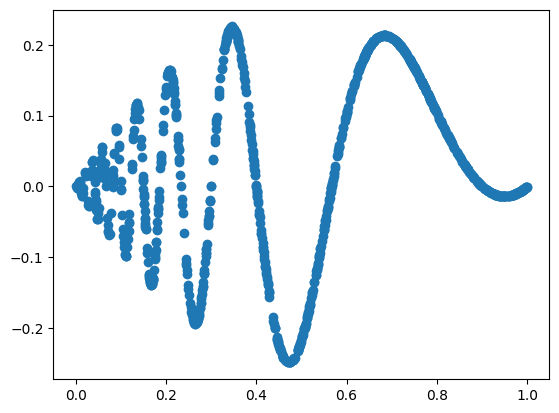

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from kan.utils import create_dataset

torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is: ',device)

f = lambda x: x[:,[0]]*(1-x[:,[0]])*torch.sin((2*np.pi)/(x[:,[0]]+.1))

dataset = create_dataset(f, n_var=1, device=device, ranges=[0,1])

print('train input data shape', dataset['train_input'].shape)
print('train label data shape', dataset['train_label'].shape)

plt.scatter(dataset['train_input'],dataset['train_label'])

In [4]:
# Define model
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class ChebyKAN(nn.Module):
    def __init__(self):
        super(ChebyKAN, self).__init__()
        self.chebykan1 = ChebyKANLayer(1, 5, 4)
        self.ln1 = nn.LayerNorm(5) # To avoid gradient vanishing caused by tanh
        self.chebykan2 = ChebyKANLayer(5, 5, 4)
        self.ln2 = nn.LayerNorm(5)
        self.chebykan3 = ChebyKANLayer(5, 1, 4)

    def forward(self, x):
        x = self.chebykan1(x)
        x = self.ln1(x)
        x = self.chebykan2(x)
        x = self.ln2(x)
        x = self.chebykan3(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a KAN: 1D inputs, 1D output, and 5 hidden neurons.
model =ChebyKAN()
model.to(device)

# Define loss
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [5]:
def train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses):
    for epoch in range(num_epochs):
        #clear out the gradients from the last step loss.backward()
        model.train()
        optimizer.zero_grad()
        
        #forward feed
        output_train = model(X_train)

        #calculate the loss
        loss_train = criterion(output_train, y_train)


        #backward propagation: calculate gradients
        loss_train.backward()

        #update the weights
        optimizer.step()
        
        model.eval()
        output_test = model(X_test)
        loss_test = criterion(output_test,y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")
    return model, train_losses, test_losses



import numpy as np
num_epochs = 1000
train_losses = np.zeros(num_epochs)
test_losses  = np.zeros(num_epochs)
X_train = dataset['train_input']
y_train = dataset['train_label']
X_test = dataset['test_input']
y_test = dataset['test_label']
mlp, train_losses, test_losses = train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses)

Epoch 50/1000, Train Loss: 0.0079, Test Loss: 0.0079
Epoch 100/1000, Train Loss: 0.0049, Test Loss: 0.0046
Epoch 150/1000, Train Loss: 0.0041, Test Loss: 0.0037
Epoch 200/1000, Train Loss: 0.0027, Test Loss: 0.0025
Epoch 250/1000, Train Loss: 0.0018, Test Loss: 0.0016
Epoch 300/1000, Train Loss: 0.0014, Test Loss: 0.0014
Epoch 350/1000, Train Loss: 0.0085, Test Loss: 0.0093
Epoch 400/1000, Train Loss: 0.0013, Test Loss: 0.0013
Epoch 450/1000, Train Loss: 0.0007, Test Loss: 0.0008
Epoch 500/1000, Train Loss: 0.0005, Test Loss: 0.0005
Epoch 550/1000, Train Loss: 0.0004, Test Loss: 0.0005
Epoch 600/1000, Train Loss: 0.0006, Test Loss: 0.0006
Epoch 650/1000, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 700/1000, Train Loss: 0.0002, Test Loss: 0.0003
Epoch 750/1000, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 800/1000, Train Loss: 0.0001, Test Loss: 0.0002
Epoch 850/1000, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 900/1000, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 950/1000, Train Loss: 0

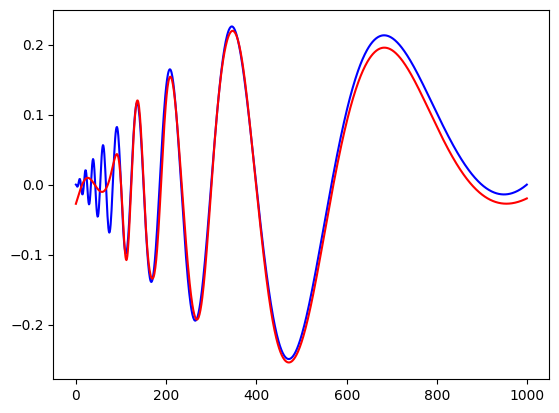

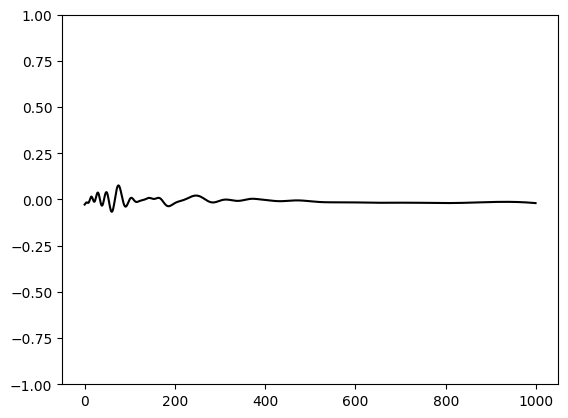

In [6]:
# let us look at the recontruction
X = dataset['train_input']
n  = 1000
X[:,0] = torch.linspace(0,1,steps=n)
y = f(X)
y = y[:,0].detach().numpy()
yh = model.forward(X)

yh = yh[:,0].detach().numpy()
plt.plot(y,color='blue')
plt.plot(yh, color='red')
plt.show()
plt.plot(yh-y, color='black')
plt.ylim(-1,1)
plt.show()